https://github.com/timesler/facenet-pytorch/blob/master/examples/finetune.ipynb 

In [15]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import numpy as np 
import os
import matplotlib.pyplot as plt
import pandas as pd
import face_recognition

from sklearn.metrics import accuracy_score,f1_score,precision_score
from torchsummaryX import summary
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


# Data Download and Processing

In [16]:
# set working directory
data_dir = '/data_seoul/dain5832/cmu/summer/celebA/celeba'
os.chdir(data_dir)
os.getcwd()

'/data_seoul/dain5832/cmu/summer/celebA/celeba'

In [ ]:
# download dataset
import gdown
output = 'img_align_celeba.zip'
url = 'https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?usp=sharing&resourcekey=0-dYn9z10tMJOBAkviAcfdyQ'
gdown.download(url=url, output=output, fuzzy=True)


In [ ]:
# extract zipfile
from zipfile import ZipFile
ZipFile(os.path.join(data_dir, 'img_align_celeba.zip')).extractall()

In [18]:
# load annotation file
df_attr = pd.read_csv('/data_seoul/dain5832/cmu/summer/celebA/celeba/list_attr_celeba.txt', delim_whitespace=True, header=1)
df_attr.replace(-1,0,inplace=True)
df_attr.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


  5%|▍         | 68.2M/1.44G [00:19<00:39, 35.1MB/s]

In [19]:
batch_size = 128
workers = 0 if os.name == 'nt' else 8

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

dataset = datasets.CelebA(root='/data_seoul/dain5832/cmu/summer/celebA', split='valid', target_type='attr', transform=trans)

img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.2 * len(img_inds))]
val_inds = img_inds[int(0.2 * len(img_inds)):int(0.25 * len(img_inds))]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

In [20]:
for (x,y) in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 3, 218, 178]) torch.Size([128, 40])


# Load Pretrained Model

In [21]:
class InceptionResnetV1_multilabel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, n_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize the model
model = InceptionResnetV1_multilabel(40).to(device)

y_true:  ['Bags_Under_Eyes', 'High_Cheekbones', 'Mustache', 'Oval_Face', 'Receding_Hairline', 'Wearing_Earrings', 'Wearing_Necklace']
y_pred:  ['Attractive', 'Bald', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Eyeglasses', 'Goatee', 'High_Cheekbones', 'Male', 'Mustache', 'Receding_Hairline', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Necklace', 'Wearing_Necktie']


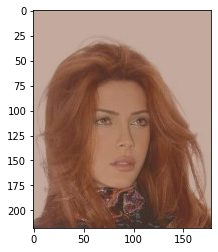

In [22]:
# load model into memory
model.eval()

# model inference on a pretrained model
for (images, attr) in train_loader:
    idx= 0
    y_pred = model(images.to(device))
    prediction=torch.round(torch.sigmoid(y_pred)).detach().cpu()

    images=images.cpu().numpy().transpose((0,2,3,1))
    plt.imshow(images[idx]*[0.2644, 0.2436, 0.2397]+[0.5063, 0.4258, 0.3832])
    labels=df_attr.columns.tolist()
    labels=labels[1:]
    att=attr[idx].numpy()
    prediction = prediction[idx].numpy().astype(int)
    label_str="\n".join([label for label,a in list(zip(labels,att)) if a==1])
    #preds = "\n".join([label for label,a in list(zip(labels,prediction)) if a==1])
    print("y_true: ", [label for label,a in list(zip(labels,att)) if a==1])
    print("y_pred: ", [label for label,a in list(zip(labels,prediction)) if a==1])
    plt.show()
    break

# Transfer Learning

In [23]:
epochs = 5
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

loss_fn = torch.nn.BCEWithLogitsLoss()
metrics = {}

In [24]:
def run_epoch(
    model, loss_fn, loader, optimizer=None, scheduler=None,
    batch_metrics={}, show_running=True,
    device='cpu', writer=None
):
    
    mode = 'Train' if model.training else 'Valid'
    logger = training.Logger(mode, length=len(loader), calculate_mean=show_running)
    loss = 0
    metrics = {}
    y_preds, targets = [], []
    for i_batch, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        prediction=torch.round(torch.sigmoid(y_pred))
        y_preds.append(prediction.detach().cpu())
        targets.append(y.detach().cpu())
        loss_batch = loss_fn(y_pred.to(torch.float32), y.to(torch.float32))

        if model.training:
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

        metrics_batch = {}
        for metric_name, metric_fn in batch_metrics.items():
            if metric_name == 'fps':
                metrics_batch[metric_name] = metric_fn(y_pred.detach().cpu().numpy(), y.detach().cpu().numpy()).detach().cpu()
                metrics[metric_name] = metrics.get(metric_name, 0) + metrics_batch[metric_name]
        
        if writer is not None and model.training:
            if writer.iteration % writer.interval == 0:
                writer.add_scalars('loss', {mode: loss_batch.detach().cpu()}, writer.iteration)
                for metric_name, metric_batch in metrics_batch.items():
                    writer.add_scalars(metric_name, {mode: metric_batch}, writer.iteration)
            writer.iteration += 1
        
        loss_batch = loss_batch.detach().cpu()
        loss += loss_batch
        if show_running:
            logger(loss, metrics, i_batch)
        else:
            logger(loss_batch, metrics_batch, i_batch)
    
    if model.training and scheduler is not None:
        scheduler.step()

    loss = loss / (i_batch + 1)
    metrics = {k: v / (i_batch + 1) for k, v in metrics.items()}
    f1=round(f1_score(torch.cat(targets,dim=0).numpy(),torch.cat(y_preds,dim=0).numpy(),average='samples'), 3)
    precision = round(precision_score(torch.cat(targets,dim=0).numpy(),torch.cat(y_preds,dim=0).numpy(),average='samples'), 3)
    
    print('f1score:', f1)
    print('precision:', precision)
    
    if writer is not None and not model.training:
        writer.add_scalars('loss', {mode: loss.detach()}, writer.iteration)
        for metric_name, metric in metrics.items():
            writer.add_scalars(metric_name, {mode: metric})

    return loss, metrics

In [25]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
model.eval()
run_epoch(
    model, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    model.train()
    run_epoch(
        model, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    model.eval()
    run_epoch(
        model, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )
    torch.save(model.state_dict(), 'model_resnet34_{}.pth'.format(epoch))

writer.close()



Initial
----------
Valid |     8/8    | loss:    0.7177 |    
f1score: 0.342
precision: 0.249

Epoch 1/5
----------
Train |    32/32   | loss:    0.3072 |    
f1score: 0.648
precision: 0.783
Valid |     8/8    | loss:    0.2836 |    
f1score: 0.694
precision: 0.738

Epoch 2/5
----------
Train |    32/32   | loss:    0.2331 |    
f1score: 0.731
precision: 0.83
Valid |     8/8    | loss:    0.2697 |    
f1score: 0.7
precision: 0.78

Epoch 3/5
----------
Train |    32/32   | loss:    0.2121 |    
f1score: 0.759
precision: 0.85
Valid |     8/8    | loss:    0.2782 |    
f1score: 0.676
precision: 0.777

Epoch 4/5
----------
Train |    32/32   | loss:    0.1929 |    
f1score: 0.786
precision: 0.864
Valid |     8/8    | loss:    0.2543 |    
f1score: 0.704
precision: 0.814

Epoch 5/5
----------
Train |    32/32   | loss:    0.1742 |    
f1score: 0.809
precision: 0.875
Valid |     8/8    | loss:    0.2512 |    
f1score: 0.723
precision: 0.784


## Inference Using a New Model

In [27]:
trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
# call a new dataset
dataset = datasets.CelebA(root='/data_seoul/dain5832/cmu/summer/celebA', split='test', target_type='attr', transform=trans)

img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)

test_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(img_inds)
)

40
[(68, 139, 175, 32)]


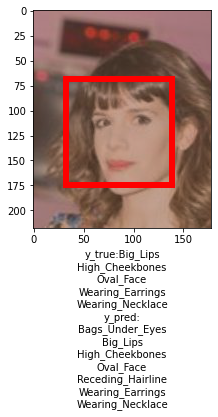

In [28]:
from PIL import Image, ImageDraw
import numpy as np
from torchvision.transforms import ToPILImage
from matplotlib.patches import Rectangle

for (images, attr) in test_loader:
    fig, ax = plt.subplots()
    idx= 0
    y_pred = model(images.to(device))
    prediction=torch.round(torch.sigmoid(y_pred)).detach().cpu()
    img = ToPILImage()(images[0])
    images=images.cpu().numpy().transpose((0,2,3,1))
    plt.imshow(images[idx]*[0.2644, 0.2436, 0.2397]+[0.5063, 0.4258, 0.3832])
    labels=df_attr.columns.tolist()
    labels=labels[1:]
    att=attr[idx].numpy()
    prediction = prediction[idx].numpy().astype(int)
    print(len(prediction))
    preds = ""
    for label,a in list(zip(labels,prediction)):
        if a== 1:
            preds+= "\n"+label
    labels="\n".join([label for label,a in list(zip(labels,att)) if a==1])

    # detect face
    face_locations = face_recognition.api.face_locations(np.array(img))
    frame_draw = img.copy()
    draw = ImageDraw.Draw(frame_draw)

    for face_location in face_locations:
        draw.rectangle(list(face_location), outline=(255, 0, 0), width=6)
    print(face_locations)
    plt.xlabel("y_true:"+labels+"\n"+"y_pred:"+preds)
    if face_locations:
        ax.add_patch(Rectangle((face_location[3], face_location[0]), face_location[1]-face_location[3], face_location[2]-face_location[0], linewidth=6, edgecolor='r', fill=False))
    break